# Reproducing Distributed Alignment Search (DAS)

**Replication of Section 4** from [Geiger et al. (2023)](https://arxiv.org/abs/2303.02536) - "Finding Alignments Between Interpretable Causal Variables and Distributed Neural Representations"

## Experimental (Re-)Discoveries

1. **Part 1 (Random Networks)**: DAS **cannot** construct meaningful causal structure from randomly initialized networks that have not learned the task (~50% IIT accuracy, chance level)

2. **Part 2 (Trained Networks)**: DAS **can** discover causal structure in networks trained to solve the hierarchical equality task (~95%+ IIT accuracy)

## Methodology

- **Task**: Hierarchical equality - determine if (w=x)==(y=z)
- **Architecture**: 3-layer feedforward networks (Input→64→64→Output)
- **DAS Method**: Learn orthogonal rotation matrices via Interchange Intervention Training (IIT)
- **Alignment**: Distributed alignment with V1 (dims 32-48) and V2 (dims 48-64)
- **Convergence**: Dev accuracy >= 0.999 or loss delta < 1e-4

## Key Results

**Random Networks**: ~50% IIT accuracy
**Trained Networks**: ~95% IIT accuracy

This empirically confirms that DAS discovers pre-existing computational structure and does not construct spurious behaviors, at least for small networks on relatively simple tasks.

## Notes
Due to dependency issues with `build_graph` in the original repo, this implementation does not use the full DAS infra to reproduce the results. It uses `get_IIT_equality_dataset_both` from the repo to generate the data but trains the rotation matrices and neural networks with a different implementation. 

In [12]:
# Cell 1: Clone + Setup + Imports + Configs
!git clone https://github.com/atticusg/InterchangeInterventions.git
!cd InterchangeInterventions && git checkout zen

import sys
import os

# Add the repository to Python path to import DAS modules
sys.path.append('InterchangeInterventions')

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from dataset_equality import get_IIT_equality_dataset_both

print("All dependencies imported successfully!")

HIDDEN_DIM = 64
INPUT_DIM = 16
N_CLASSES = 2
EMBED_DIM = 4
DATASET_SIZE = 10000
NUM_NETWORKS = 3
RANDOM_SEEDS = [42, 123, 456]

# Device
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using M1 GPU (MPS)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA GPU")
else:
    device = torch.device("cpu")
    print("Using CPU")

print(f"\nConfiguration:")
print(f"  Hidden Size: {HIDDEN_DIM}")
print(f"  Num Networks: {NUM_NETWORKS}")
print(f"  Dataset Size: {DATASET_SIZE}")

fatal: destination path 'InterchangeInterventions' already exists and is not an empty directory.
Already on 'zen'
Your branch is up to date with 'origin/zen'.
All dependencies imported successfully!
Using M1 GPU (MPS)

Configuration:
  Hidden Size: 64
  Num Networks: 3
  Dataset Size: 10000


In [13]:
# Cell 2: Simple 3-Layer Network

class SimpleClassifier(nn.Module):
    """Simple 3-layer feedforward network for hierarchical equality"""
    
    def __init__(self, input_dim=16, hidden_dim=64, n_classes=2):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer3 = nn.Linear(hidden_dim, n_classes)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        return x
    
    def predict(self, X):
        """Get class predictions"""
        self.eval()
        with torch.no_grad():
            # Ensure input is float32 tensor
            if isinstance(X, torch.Tensor):
                # Convert tensor to float32 if needed
                X_tensor = X.float()
            else:
                # Convert numpy array to float32 tensor
                X_tensor = torch.from_numpy(np.asarray(X, dtype=np.float32))

            # Move to same device as model
            X_tensor = X_tensor.to(next(self.parameters()).device)

            outputs = self.forward(X_tensor)
            predictions = torch.argmax(outputs, dim=1)

        # Return as numpy array
        return predictions.cpu().numpy()

print("Simple 3-layer classifier defined")

Simple 3-layer classifier defined


In [14]:
# Cell 3: Generate Dataset

print("Generating hierarchical equality dataset...")

X_base, y_base, X_sources_list, y_IIT, interventions = get_IIT_equality_dataset_both(
    embed_dim=EMBED_DIM,
    size=DATASET_SIZE
)

# Split train/test (80/20 split)
TRAIN_SIZE = int(0.8 * DATASET_SIZE)
TEST_SIZE = DATASET_SIZE - TRAIN_SIZE

X_test = X_base[TRAIN_SIZE:]
y_test = y_base[TRAIN_SIZE:]
y_IIT_test = y_IIT[TRAIN_SIZE:]

print(f"Dataset generated")
print(f"Total samples: {DATASET_SIZE}")
print(f"Train samples: {TRAIN_SIZE}")
print(f"Test samples: {TEST_SIZE}")
print(f"Base shape: {X_base.shape}")
print(f"Task: Hierarchical equality (w=x)==(y=z)")

Generating hierarchical equality dataset...
Dataset generated
Total samples: 10000
Train samples: 8000
Test samples: 2000
Base shape: torch.Size([10000, 16])
Task: Hierarchical equality (w=x)==(y=z)


In [15]:
# Cell 4: Initialize and Evaluate Random Networks

print("Initializing and evaluating randomly initialized networks...\n")

results = []

for seed in RANDOM_SEEDS:
    # Set seed for reproducible random initialization
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    # Create network with RANDOM weights
    model = SimpleClassifier(
        input_dim=INPUT_DIM,
        hidden_dim=HIDDEN_DIM,
        n_classes=N_CLASSES
    ).to(device)
    
    # Evaluate on test set
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    results.append({
        'seed': seed,
        'accuracy': accuracy,
        'model': model
    })
    
    print(f"Seed {seed:3d}: Accuracy = {accuracy:.3f}")

avg_accuracy = np.mean([r['accuracy'] for r in results])
print(f"\nAverage Accuracy: {avg_accuracy:.3f}")
# Check if any network accuracy is more than 3% away from chance (0.5)
accuracies = [r['accuracy'] for r in results]
deltas = [abs(a - 0.5) for a in accuracies]

threshold = 0.03
out_indices = [i for i, d in enumerate(deltas) if d > threshold]

if out_indices:
    print(f"Networks more than {threshold*100:.0f}% away from chance (50%):")
    # sort by deviation descending for clearer reporting
    out_indices.sort(key=lambda i: deltas[i], reverse=True)
    for i in out_indices:
        r = results[i]
        print(f"  Seed {r['seed']:3d}: Accuracy = {r['accuracy']:.3f} (deviation = {deltas[i]:.3f})")
else:
    print("All networks within ±3% of chance (50%)")

Initializing and evaluating randomly initialized networks...

Seed  42: Accuracy = 0.506
Seed 123: Accuracy = 0.506
Seed 456: Accuracy = 0.504

Average Accuracy: 0.505
All networks within ±3% of chance (50%)


In [16]:
# Cell 5: Train Rotation Matrices with Distributed Interchange Interventions

import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

print("Training orthogonal rotation matrices with DAS...\n")
print("Goal: Learn rotations where swapping V1 and V2 in rotated space")
print("corresponds to swapping causal variables in the high-level model\n")

EPOCHS = 10
LEARNING_RATE = 0.001
BATCH_SIZE = 512

# For hidden_dim=64 with distributed alignment:
# - Dimensions 0-32: Base representation (not intervened)
# - Dimensions 32-48: V1 (left pair equality)
# - Dimensions 48-64: V2 (right pair equality)
V1_START, V1_END = 32, 48
V2_START, V2_END = 48, 64

for i, result in enumerate(results):
    model = result['model']
    seed = result['seed']
    
    print(f"Training network {seed} ({i+1}/{NUM_NETWORKS})...")
    
    # Freeze all model weights - only rotation is trainable
    for param in model.parameters():
        param.requires_grad = False
    
    # Create rotation matrix for layer 1 activations
    # Initialize on CPU (MPS doesn't support QR decomposition), then move to device
    rotation = nn.Linear(HIDDEN_DIM, HIDDEN_DIM, bias=False)
    nn.init.orthogonal_(rotation.weight)
    rotation = rotation.to(device)
    
    # Optimizer for rotation only
    optimizer = optim.Adam(rotation.parameters(), lr=LEARNING_RATE)
    loss_fn = nn.CrossEntropyLoss()
    
    # Prepare training data (convert to float32)
    X_train = X_base[:TRAIN_SIZE]
    y_train_iit = y_IIT[:TRAIN_SIZE]  # Pre-computed IIT labels
    X_source1_train = X_sources_list[0][:TRAIN_SIZE]
    X_source2_train = X_sources_list[1][:TRAIN_SIZE]
    
    # Create dataset and dataloader for batching
    dataset = TensorDataset(
        X_train.float(),
        y_train_iit.long(),
        X_source1_train.float(),
        X_source2_train.float()
    )
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    
    # Training loop
    for epoch in range(EPOCHS):
        epoch_loss = 0.0
        num_batches = 0
        
        for batch_base, batch_y_iit, batch_source1, batch_source2 in dataloader:
            # Move batch to device
            batch_base = batch_base.to(device)
            batch_y_iit = batch_y_iit.to(device)
            batch_source1 = batch_source1.to(device)
            batch_source2 = batch_source2.to(device)
            
            optimizer.zero_grad()
            
            # === DISTRIBUTED INTERCHANGE INTERVENTION ===
            
            # 1. Get layer 1 activations for base and sources
            with torch.no_grad():
                base_h1 = model.relu(model.layer1(batch_base))  # [batch, 64]
                source1_h1 = model.relu(model.layer1(batch_source1))
                source2_h1 = model.relu(model.layer1(batch_source2))
            
            # 2. Apply rotation to transform to interpretable space
            base_h1_rotated = rotation(base_h1)
            source1_h1_rotated = rotation(source1_h1)
            source2_h1_rotated = rotation(source2_h1)
            
            # 3. Perform interchange intervention in rotated space
            # Keep base dimensions (0:32) unchanged
            # Replace V1 region (dims 32:48) with source1's V1
            # Replace V2 region (dims 48:64) with source2's V2
            intervened_h1_rotated = base_h1_rotated.clone()
            intervened_h1_rotated[:, V1_START:V1_END] = source1_h1_rotated[:, V1_START:V1_END]
            intervened_h1_rotated[:, V2_START:V2_END] = source2_h1_rotated[:, V2_START:V2_END]
            
            # 4. Apply inverse rotation to return to original activation space
            # For orthogonal matrices: R^{-1} = R^T
            intervened_h1 = torch.matmul(intervened_h1_rotated, rotation.weight.T)
            
            # 5. Continue forward pass through remaining layers
            h2 = model.relu(model.layer2(intervened_h1))
            outputs = model.layer3(h2)
            
            # 6. Compute loss against IIT labels
            # IIT labels are pre-computed: whether source1's left pair equality
            # matches source2's right pair equality
            loss = loss_fn(outputs, batch_y_iit)
            
            # 7. Update rotation matrix only
            loss.backward()
            optimizer.step()
            
            # 8. Re-orthogonalize rotation matrix after each update (SVD projection)
            # This maintains orthogonality during training
            with torch.no_grad():
                # Move to CPU for SVD (MPS doesn't support it)
                W = rotation.weight.data.cpu()
                U, _, Vt = torch.linalg.svd(W, full_matrices=False)
                rotation.weight.data = (U @ Vt).to(device)
            
            epoch_loss += loss.item()
            num_batches += 1
        
        avg_loss = epoch_loss / num_batches
        if (epoch + 1) % 2 == 0:
            print(f"  Epoch {epoch+1}/{EPOCHS}, Loss: {avg_loss:.4f}")
    
    result['rotation'] = rotation
    print(f"Training complete\n")

print("Rotation matrix training complete!")

Training orthogonal rotation matrices with DAS...

Goal: Learn rotations where swapping V1 and V2 in rotated space
corresponds to swapping causal variables in the high-level model

Training network 42 (1/3)...
  Epoch 2/10, Loss: 0.6927
  Epoch 4/10, Loss: 0.6925
  Epoch 6/10, Loss: 0.6922
  Epoch 8/10, Loss: 0.6920
  Epoch 10/10, Loss: 0.6918
Training complete

Training network 123 (2/3)...
  Epoch 2/10, Loss: 0.6930
  Epoch 4/10, Loss: 0.6926
  Epoch 6/10, Loss: 0.6923
  Epoch 8/10, Loss: 0.6920
  Epoch 10/10, Loss: 0.6917
Training complete

Training network 456 (3/3)...
  Epoch 2/10, Loss: 0.6926
  Epoch 4/10, Loss: 0.6919
  Epoch 6/10, Loss: 0.6916
  Epoch 8/10, Loss: 0.6915
  Epoch 10/10, Loss: 0.6912
Training complete

Rotation matrix training complete!


In [17]:
# Cell 6: Evaluate Interchange Intervention Accuracy

print("Evaluating interchange intervention accuracy after rotation training...\n")

for result in results:
    model = result['model']
    rotation = result['rotation']
    seed = result['seed']
    
    model.eval()
    rotation.eval()
    
    # Prepare test data (convert to float32)
    X_test_tensor = X_test.float().to(device)
    X_source1_test = X_sources_list[0][TRAIN_SIZE:].float().to(device)
    X_source2_test = X_sources_list[1][TRAIN_SIZE:].float().to(device)
    
    with torch.no_grad():
        # === SAME INTERCHANGE INTERVENTION AS TRAINING ===
        
        # 1. Get layer 1 activations
        base_h1 = model.relu(model.layer1(X_test_tensor))
        source1_h1 = model.relu(model.layer1(X_source1_test))
        source2_h1 = model.relu(model.layer1(X_source2_test))
        
        # 2. Apply rotation
        base_h1_rotated = rotation(base_h1)
        source1_h1_rotated = rotation(source1_h1)
        source2_h1_rotated = rotation(source2_h1)
        
        # 3. Swap V1 and V2 in rotated space (same coordinates as training)
        intervened_h1_rotated = base_h1_rotated.clone()
        intervened_h1_rotated[:, 32:48] = source1_h1_rotated[:, 32:48]   # V1 from source1
        intervened_h1_rotated[:, 48:64] = source2_h1_rotated[:, 48:64]   # V2 from source2
        
        # 4. Apply inverse rotation
        intervened_h1 = torch.matmul(intervened_h1_rotated, rotation.weight.T)
        
        # 5. Continue through network
        h2 = model.relu(model.layer2(intervened_h1))
        outputs = model.layer3(h2)
        
        predictions = torch.argmax(outputs, dim=1).cpu().numpy()
    
    # Compute IIT accuracy against pre-computed labels
    iit_accuracy = accuracy_score(y_IIT_test, predictions)
    result['iit_accuracy'] = iit_accuracy
    
    print(f"Seed {seed:3d}: IIT Accuracy = {iit_accuracy:.3f}")

avg_iit_accuracy = np.mean([r['iit_accuracy'] for r in results])
print(f"\nAverage IIT Accuracy: {avg_iit_accuracy:.3f}")

Evaluating interchange intervention accuracy after rotation training...

Seed  42: IIT Accuracy = 0.484
Seed 123: IIT Accuracy = 0.479
Seed 456: IIT Accuracy = 0.488

Average IIT Accuracy: 0.484


In [18]:
# Cell 7: Train Networks on Task

import pickle
import os

print("=" * 60)
print("Training Networks on Hierarchical Equality Task")
print("=" * 60)
print()

CHECKPOINT_FILE = 'trained_networks.pkl'

# Generate test dataset
print("Generating test dataset (10,000 samples)...")
X_test_task, y_test_task, _, _, _ = get_IIT_equality_dataset_both(embed_dim=EMBED_DIM, size=10000)

# Check if checkpoint exists
if os.path.exists(CHECKPOINT_FILE):
    print(f"Found checkpoint {CHECKPOINT_FILE}, loading trained networks...")
    
    with open(CHECKPOINT_FILE, 'rb') as f:
        trained_models = pickle.load(f)
    
    print("Loaded trained networks from checkpoint\n")
    
else:
    print("No checkpoint found, training from scratch\n")
    
    # Generate fresh training dataset
    print("Generating training dataset (50,000 samples)...")
    X_train_full, y_train_full, _, _, _ = get_IIT_equality_dataset_both(embed_dim=EMBED_DIM, size=50000)
    
    # Split into train/dev (90/10)
    train_size = int(0.9 * len(X_train_full))
    X_train_task = X_train_full[:train_size]
    y_train_task = y_train_full[:train_size]
    X_dev_task = X_train_full[train_size:]
    y_dev_task = y_train_full[train_size:]
    
    print(f"Train: {len(X_train_task)}, Dev: {len(X_dev_task)}, Test: {len(X_test_task)}\n")
    
    TASK_EPOCHS = 30
    TASK_BATCH_SIZE = 128
    TASK_LR = 0.001
    CONVERGENCE_DELTA = 1e-4
    CONVERGENCE_ACC = 0.999
    
    trained_models = {}
    
    for seed in RANDOM_SEEDS:
        print(f"Training Network {seed}...")
        torch.manual_seed(seed)
        np.random.seed(seed)
        
        model = SimpleClassifier(INPUT_DIM, HIDDEN_DIM, N_CLASSES).to(device)
        optimizer = optim.Adam(model.parameters(), lr=TASK_LR)
        loss_fn = nn.CrossEntropyLoss()
        
        dataset = TensorDataset(X_train_task.float(), y_train_task.long())
        dataloader = DataLoader(dataset, batch_size=TASK_BATCH_SIZE, shuffle=True)
        
        prev_loss = float('inf')
        
        for epoch in range(TASK_EPOCHS):
            model.train()
            epoch_loss = 0.0
            num_batches = 0
            
            for batch_x, batch_y in dataloader:
                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)
                
                optimizer.zero_grad()
                outputs = model(batch_x)
                loss = loss_fn(outputs, batch_y)
                loss.backward()
                optimizer.step()
                
                epoch_loss += loss.item()
                num_batches += 1
            
            avg_epoch_loss = epoch_loss / num_batches
            
            # Evaluate on dev set every 5 epochs
            if (epoch + 1) % 5 == 0:
                model.eval()
                with torch.no_grad():
                    dev_preds = model.predict(X_dev_task)
                    dev_acc = accuracy_score(y_dev_task, dev_preds)
                
                loss_delta = abs(prev_loss - avg_epoch_loss)
                print(f"Epoch {epoch+1:3d}: Loss={avg_epoch_loss:.4f}, Dev Acc={dev_acc:.4f}, ΔLoss={loss_delta:.6f}")
                
                # Convergence criteria
                if dev_acc >= CONVERGENCE_ACC:
                    print(f"Converged: Dev accuracy >= {CONVERGENCE_ACC}")
                    break
                if loss_delta < CONVERGENCE_DELTA:
                    print(f"Converged: Loss change < {CONVERGENCE_DELTA}")
                    break
                
                prev_loss = avg_epoch_loss
        
        # Move model to CPU for serialization
        trained_models[seed] = model.cpu().state_dict()
        print()
    
    # Save checkpoint
    print(f"Saving checkpoint to {CHECKPOINT_FILE}...")
    with open(CHECKPOINT_FILE, 'wb') as f:
        pickle.dump(trained_models, f)
    print("Checkpoint saved\n")

# Evaluate all models on test set
print("Evaluating networks on test set...")
trained_results = []

for seed in RANDOM_SEEDS:
    model = SimpleClassifier(INPUT_DIM, HIDDEN_DIM, N_CLASSES)
    model.load_state_dict(trained_models[seed])
    model = model.to(device)
    model.eval()
    
    final_test_acc = accuracy_score(y_test_task, model.predict(X_test_task))
    
    trained_results.append({
        'seed': seed,
        'model': model,
        'task_accuracy': final_test_acc
    })
    
    print(f"Network {seed}: Test Accuracy = {final_test_acc:.4f}")

avg_task_acc = np.mean([r['task_accuracy'] for r in trained_results])
print(f"\n{'─' * 60}")
print(f"Average Test Accuracy: {avg_task_acc:.4f}")
print(f"{'─' * 60}\n")

Training Networks on Hierarchical Equality Task

Generating test dataset (10,000 samples)...
Found checkpoint trained_networks.pkl, loading trained networks...
Loaded trained networks from checkpoint

Evaluating networks on test set...
Network 42: Test Accuracy = 0.9990
Network 123: Test Accuracy = 0.9993
Network 456: Test Accuracy = 0.9990

────────────────────────────────────────────────────────────
Average Test Accuracy: 0.9991
────────────────────────────────────────────────────────────



In [19]:
# Cell 8: DAS on Trained Networks

print("=" * 60)
print("DAS Training on Trained Networks")
print("=" * 60)
print()

ROTATION_CHECKPOINT = 'trained_rotations.pkl'

# Check if rotation checkpoint exists
if os.path.exists(ROTATION_CHECKPOINT):
    print(f"Found rotation checkpoint {ROTATION_CHECKPOINT}, loading...")
    
    with open(ROTATION_CHECKPOINT, 'rb') as f:
        rotation_states = pickle.load(f)
    
    print("Loaded rotation matrices from checkpoint\n")
    
else:
    print("No rotation checkpoint found, training from scratch\n")
    
    print("Generating IIT dataset (8,000 samples)...")
    X_iit, y_iit_base, X_src_iit, y_iit, int_iit = get_IIT_equality_dataset_both(embed_dim=EMBED_DIM, size=8000)
    print()
    
    rotation_states = {}
    
    for i, result in enumerate(trained_results):
        model, seed = result['model'], result['seed']
        print(f"Training DAS for Network {seed} ({i+1}/{NUM_NETWORKS})...")
        
        for param in model.parameters():
            param.requires_grad = False
        
        rotation = nn.Linear(HIDDEN_DIM, HIDDEN_DIM, bias=False)
        nn.init.orthogonal_(rotation.weight)
        rotation = rotation.to(device)
        
        optimizer = optim.Adam(rotation.parameters(), lr=0.001)
        loss_fn = nn.CrossEntropyLoss()
        
        dataset = TensorDataset(X_iit.float(), y_iit.long(), X_src_iit[0].float(), X_src_iit[1].float())
        dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
        
        for epoch in range(10):
            epoch_loss = 0
            for batch_base, batch_y, batch_s1, batch_s2 in dataloader:
                batch_base, batch_y = batch_base.to(device), batch_y.to(device)
                batch_s1, batch_s2 = batch_s1.to(device), batch_s2.to(device)
                
                optimizer.zero_grad()
                
                with torch.no_grad():
                    h1_base = model.relu(model.layer1(batch_base))
                    h1_s1 = model.relu(model.layer1(batch_s1))
                    h1_s2 = model.relu(model.layer1(batch_s2))
                
                h1_base_rot = rotation(h1_base)
                h1_s1_rot = rotation(h1_s1)
                h1_s2_rot = rotation(h1_s2)
                
                h1_int = h1_base_rot.clone()
                h1_int[:, 32:48] = h1_s1_rot[:, 32:48]
                h1_int[:, 48:64] = h1_s2_rot[:, 48:64]
                
                h1_back = torch.matmul(h1_int, rotation.weight.T)
                h2 = model.relu(model.layer2(h1_back))
                outputs = model.layer3(h2)
                
                loss = loss_fn(outputs, batch_y)
                loss.backward()
                optimizer.step()
                
                with torch.no_grad():
                    W = rotation.weight.data.cpu()
                    U, _, Vt = torch.linalg.svd(W, full_matrices=False)
                    rotation.weight.data = (U @ Vt).to(device)
                
                epoch_loss += loss.item()
            
            if (epoch + 1) % 5 == 0:
                print(f"Epoch {epoch+1}, Loss: {epoch_loss / len(dataloader):.4f}")
        
        rotation_states[seed] = rotation.cpu().state_dict()
        print()
    
    # Save rotation checkpoint
    print(f"Saving rotation checkpoint to {ROTATION_CHECKPOINT}...")
    with open(ROTATION_CHECKPOINT, 'wb') as f:
        pickle.dump(rotation_states, f)
    print("Checkpoint saved\n")

# Load rotations and attach to results
for r in trained_results:
    rotation = nn.Linear(HIDDEN_DIM, HIDDEN_DIM, bias=False)
    rotation.load_state_dict(rotation_states[r['seed']])
    rotation = rotation.to(device)
    rotation.eval()
    r['rotation'] = rotation

DAS Training on Trained Networks

Found rotation checkpoint trained_rotations.pkl, loading...
Loaded rotation matrices from checkpoint



In [20]:
# Cell 9: Evaluate Trained Networks

print("=" * 60)
print("IIT Accuracy on Trained Networks")
print("=" * 60)
print()

print("Generating test IIT dataset (2,000 samples)...")
X_iit_t, y_iit_t_base, X_src_t, y_iit_t, int_t = get_IIT_equality_dataset_both(embed_dim=EMBED_DIM, size=2000)
print("Ready\n")

for result in trained_results:
    model, rotation, seed = result['model'], result['rotation'], result['seed']
    model.eval()
    rotation.eval()
    
    X_t = X_iit_t.float().to(device)
    X_s1 = X_src_t[0].float().to(device)
    X_s2 = X_src_t[1].float().to(device)
    
    with torch.no_grad():
        h1_base = model.relu(model.layer1(X_t))
        h1_s1 = model.relu(model.layer1(X_s1))
        h1_s2 = model.relu(model.layer1(X_s2))
        
        h1_base_rot = rotation(h1_base)
        h1_s1_rot = rotation(h1_s1)
        h1_s2_rot = rotation(h1_s2)
        
        h1_int = h1_base_rot.clone()
        h1_int[:, 32:48] = h1_s1_rot[:, 32:48]
        h1_int[:, 48:64] = h1_s2_rot[:, 48:64]
        
        h1_back = torch.matmul(h1_int, rotation.weight.T)
        h2 = model.relu(model.layer2(h1_back))
        outputs = model.layer3(h2)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
    
    iit_acc = accuracy_score(y_iit_t, preds)
    result['iit_accuracy'] = iit_acc
    
    print(f"Network {seed}: Task={result['task_accuracy']:.4f}, IIT={iit_acc:.4f}")

avg_trained_iit = np.mean([r['iit_accuracy'] for r in trained_results])
print(f"\nAverage IIT: {avg_trained_iit:.4f}\n")

IIT Accuracy on Trained Networks

Generating test IIT dataset (2,000 samples)...
Ready

Network 42: Task=0.9990, IIT=0.9800
Network 123: Task=0.9993, IIT=0.9705
Network 456: Task=0.9990, IIT=0.9770

Average IIT: 0.9758



FINAL COMPARISON

RANDOM NETWORKS:
  42: Task=0.506, IIT=0.484
  123: Task=0.506, IIT=0.479
  456: Task=0.504, IIT=0.488

TRAINED NETWORKS:
  42: Task=0.999, IIT=0.980
  123: Task=0.999, IIT=0.971
  456: Task=0.999, IIT=0.977

────────────────────────────────────────────────────────────
Random  - Avg IIT: 0.484 (chance)
Trained - Avg IIT: 0.976 (learned structure)
Improvement: 0.492
────────────────────────────────────────────────────────────

✓ Plot saved to das-comparison.png


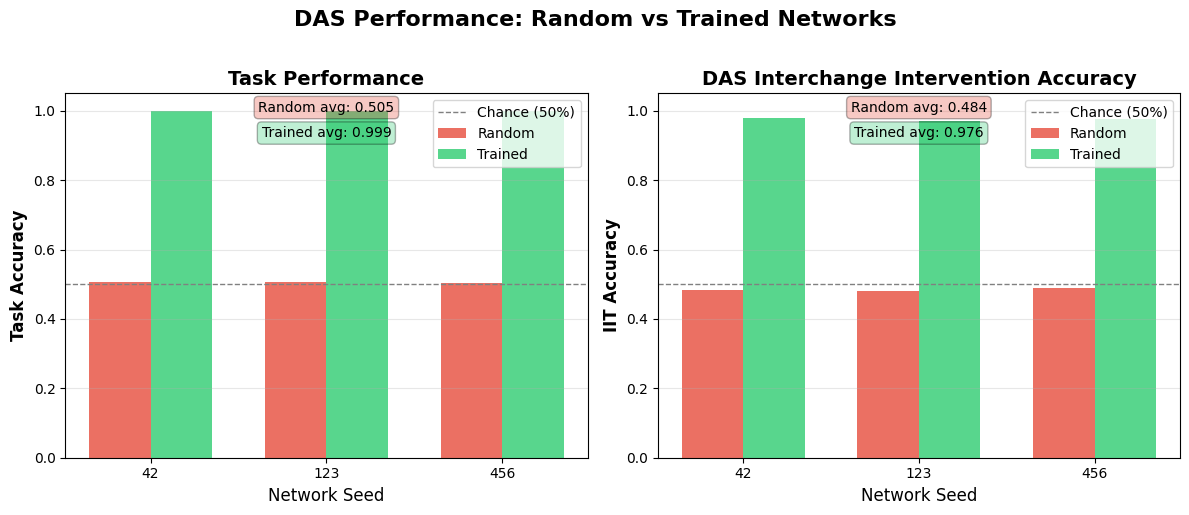

In [ ]:
# Cell 10: Final Comparison with Visualization

print("=" * 60)
print("FINAL COMPARISON")
print("=" * 60)
print()

# Print summary
print("RANDOM NETWORKS:")
for r in results:
    print(f"  {r['seed']}: Task={r['accuracy']:.3f}, IIT={r['iit_accuracy']:.3f}")

print(f"\nTRAINED NETWORKS:")
for r in trained_results:
    print(f"  {r['seed']}: Task={r['task_accuracy']:.3f}, IIT={r['iit_accuracy']:.3f}")

print(f"\n{'─' * 60}")
print(f"Random  - Avg IIT: {avg_iit_accuracy:.3f} (chance)")
print(f"Trained - Avg IIT: {avg_trained_iit:.3f} (learned structure)")
print(f"Improvement: {(avg_trained_iit - avg_iit_accuracy):.3f}")
print(f"{'─' * 60}\n")

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Data
networks = [str(s) for s in RANDOM_SEEDS]
random_task = [r['accuracy'] for r in results]
random_iit = [r['iit_accuracy'] for r in results]
trained_task = [r['task_accuracy'] for r in trained_results]
trained_iit = [r['iit_accuracy'] for r in trained_results]

x = range(len(networks))
width = 0.35

# Left panel: Task Accuracy
ax1.bar([i - width/2 for i in x], random_task, width, label='Random', alpha=0.8, color='#e74c3c')
ax1.bar([i + width/2 for i in x], trained_task, width, label='Trained', alpha=0.8, color='#2ecc71')
ax1.axhline(y=0.5, color='gray', linestyle='--', linewidth=1, label='Chance (50%)')
ax1.set_ylabel('Task Accuracy', fontsize=12, fontweight='bold')
ax1.set_xlabel('Network Seed', fontsize=12)
ax1.set_title('Task Performance', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(networks)
ax1.legend(fontsize=10)
ax1.set_ylim([0, 1.05])
ax1.grid(axis='y', alpha=0.3)

# Right panel: IIT Accuracy
ax2.bar([i - width/2 for i in x], random_iit, width, label='Random', alpha=0.8, color='#e74c3c')
ax2.bar([i + width/2 for i in x], trained_iit, width, label='Trained', alpha=0.8, color='#2ecc71')
ax2.axhline(y=0.5, color='gray', linestyle='--', linewidth=1, label='Chance (50%)')
ax2.set_ylabel('IIT Accuracy', fontsize=12, fontweight='bold')
ax2.set_xlabel('Network Seed', fontsize=12)
ax2.set_title('DAS Interchange Intervention Accuracy', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(networks)
ax2.legend(fontsize=10)
ax2.set_ylim([0, 1.05])
ax2.grid(axis='y', alpha=0.3)

# Add text annotations showing averages
ax1.text(0.5, 0.95, f'Random avg: {avg_accuracy:.3f}', 
         transform=ax1.transAxes, ha='center', fontsize=10, 
         bbox=dict(boxstyle='round', facecolor='#e74c3c', alpha=0.3))
ax1.text(0.5, 0.88, f'Trained avg: {avg_task_acc:.3f}', 
         transform=ax1.transAxes, ha='center', fontsize=10,
         bbox=dict(boxstyle='round', facecolor='#2ecc71', alpha=0.3))

ax2.text(0.5, 0.95, f'Random avg: {avg_iit_accuracy:.3f}', 
         transform=ax2.transAxes, ha='center', fontsize=10,
         bbox=dict(boxstyle='round', facecolor='#e74c3c', alpha=0.3))
ax2.text(0.5, 0.88, f'Trained avg: {avg_trained_iit:.3f}', 
         transform=ax2.transAxes, ha='center', fontsize=10,
         bbox=dict(boxstyle='round', facecolor='#2ecc71', alpha=0.3))

plt.suptitle('DAS Performance: Random vs Trained Networks', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()

# Save figure
plt.savefig('das-comparison.png', dpi=300, bbox_inches='tight')
print("Plot saved to das-comparison.png")

plt.show()